In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
from implementations import *
from helpers import *
from preprocessing_data import *
import pandas as pd

In [3]:
pd.set_option('display.max_colwidth', 100)

## Load the training data into feature matrix, class labels, and event ids:

In [4]:
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [5]:
feature_names = init_feature_names.copy()

## Do your thing crazy machine learning thing here :) ...

### Data analysis

#### Missing data analysis

In [6]:
missing_values_row_indices = np.where(tX == -999)
print("Total number of missing values:", missing_values_row_indices[0].shape[0])
print("Number of rows with >=1 missing value:", np.unique(missing_values_row_indices).shape[0])

Total number of missing values: 1580052
Number of rows with >=1 missing value: 181891


In [7]:
# Find features with missing values
missing_values_feature_indices = np.vstack([np.argwhere(row == -999) for row in tX])
missing_values_feature_indices, occur_count = np.unique(missing_values_feature_indices, return_counts=True)

In [8]:
explanations = ["May be undefined if the topology of the event is too far from the expected topology",
                "Undefined if PRI_jet_num ≤ 1",
                "Undefined if PRI_jet_num ≤ 1",
                "Undefined if PRI_jet_num ≤ 1",
                "Undefined if PRI_jet_num ≤ 1",
                "Undefined if PRI_jet_num = 0",
                "Undefined if PRI_jet_num = 0",
                "Undefined if PRI_jet_num = 0",
                "Undefined if PRI_jet_num ≤ 1",
                "Undefined if PRI_jet_num ≤ 1",
                "Undefined if PRI_jet_num ≤ 1"]

In [9]:
# More beautiful way way to print
pd.DataFrame({"Feature name": feature_names[missing_values_feature_indices], 
              "Feature index": missing_values_feature_indices,
              "Missing values count": occur_count,
              "Explanations": explanations})

,Feature name,Feature index,Missing values count,Explanations
0,DER_mass_MMC,0,38114,May be undefined if the topology of the event is too far from the expected topology
1,DER_deltaeta_jet_jet,4,177457,Undefined if PRI_jet_num ≤ 1
2,DER_mass_jet_jet,5,177457,Undefined if PRI_jet_num ≤ 1
3,DER_prodeta_jet_jet,6,177457,Undefined if PRI_jet_num ≤ 1
4,DER_lep_eta_centrality,12,177457,Undefined if PRI_jet_num ≤ 1
5,PRI_jet_leading_pt,23,99913,Undefined if PRI_jet_num = 0
6,PRI_jet_leading_eta,24,99913,Undefined if PRI_jet_num = 0
7,PRI_jet_leading_phi,25,99913,Undefined if PRI_jet_num = 0
8,PRI_jet_subleading_pt,26,177457,Undefined if PRI_jet_num ≤ 1
9,PRI_jet_subleading_eta,27,177457,Undefined if PRI_jet_num ≤ 1


In [10]:
missing_values_row_indices = [ind for ind in range(tX.shape[0]) if -999 in tX[ind]]

#### Features distribution

In [11]:
interact_feature_hist(tX, y, feature_names)

interactive(children=(BoundedIntText(value=0, description='Feature index:', max=29), Checkbox(value=False, des…

#### Investigate PRI_jet_num feature (integer, 4 categories)

PRI_jet_num has only 4 unique values, so we can consider that this feature is categorical. Lets see distribution of features according to PRI_jet_num values

In [12]:
jet_num_index = 22

def plot_feature_hist(feature_ind, drop_nan, jet_num):   
    indices_jet_num = [ind for ind in range(tX.shape[0]) if tX[ind, jet_num_index] == jet_num]
    tX_plot = tX[indices_jet_num]
    y_plot = y[indices_jet_num]
    
    indices_class_pos = np.where(y_plot==1)
    indices_class_neg = np.where(y_plot==-1)
    
    tX_pos = tX_plot[indices_class_pos, feature_ind]
    tX_neg = tX_plot[indices_class_neg, feature_ind]

    if drop_nan:
        tX_pos = tX_pos[tX_pos != -999]
        tX_neg = tX_neg[tX_neg != -999]

    plt.figure(figsize=(15, 6), dpi=80)
    plt.subplot(1, 2, 1)
    plt.title(feature_names[feature_ind] + f" (Feature #{feature_ind})")
    plt.hist(tX_pos.T, bins=100, color="r", label="+1")
    plt.hist(tX_neg.T, bins=100, color="b", label="-1")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title(feature_names[feature_ind] + f" (Feature #{feature_ind})")
    plt.hist(tX_neg.T, bins=100, color="b", label="-1")
    plt.hist(tX_pos.T, bins=100, color="r", label="+1")
    plt.legend()
    
interact(plot_feature_hist, 
         feature_ind=widgets.BoundedIntText(value=0, min=0, max=29, step=1, description='Feature index:', disabled=False),
         jet_num=widgets.BoundedIntText(value=0, min=0, max=3, step=1, description='Jet num value:', disabled=False),
         drop_nan=widgets.Checkbox(value=False, description='Drop missing values', disabled=False)
        )
plt.show()

interactive(children=(BoundedIntText(value=0, description='Feature index:', max=29), Checkbox(value=False, des…

We see that value of jet num influences on number of missing values. Now we have to options:
* Divide our dataset on 4 parts according to PRI_jet_num values
* Create 4 boolean features instead of 1 categorical  

#### Compute features correlation

In [13]:
# If we calculate with missing values, then columns with missing data will be significantly correlated
rows_without_missing_data = list(set(range(tX.shape[0])) - set(missing_values_row_indices))
tX_without_rows_with_missing_data = tX[rows_without_missing_data, :]
y_without_rows_with_missing_data = y[rows_without_missing_data]

In [14]:
# Compute correlation of features in dataset without missing data
n_features = tX_without_rows_with_missing_data.shape[1]
corr_matrix = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(i, n_features):
        corr_matrix[i, j] = corr_matrix[j, i] = np.corrcoef(tX_without_rows_with_missing_data[:, i], 
                                                            tX_without_rows_with_missing_data[:, j])[0,1]

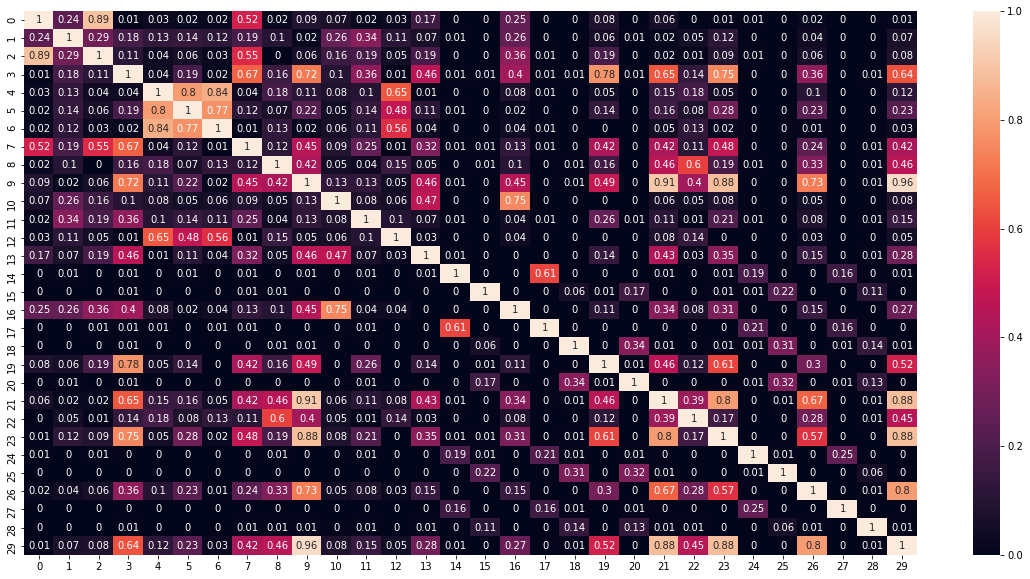

In [15]:
plt.figure(figsize=(20,10))
sns.heatmap(np.abs(np.round(corr_matrix, decimals=2)),annot=True)
plt.show()

We can find some correlated features (corr >= 0.8), lets list them:

In [16]:
correlated_features = np.where(corr_matrix >= 0.8)
correlated_features = [(i, j) for (i, j) in zip(correlated_features[0], correlated_features[1]) if i < j]
correlated_features

[(0, 2), (9, 21), (9, 23), (9, 29), (21, 23), (21, 29), (23, 29)]

So correlated are features
* 0, 2
* 9, 21, 23, 29

#### Lets have a look at balance of data

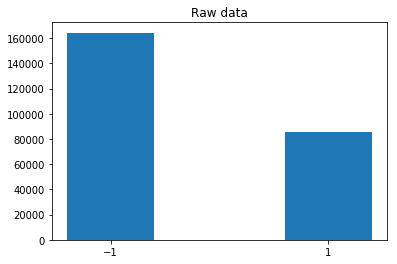

In [17]:
unique, count = np.unique(y, return_counts=True)
plt.bar(unique, count)
plt.xticks(unique)
plt.title("Raw data")
plt.show()

The major class is -1 and is approximately twice as much as minor class

#### Usefull variables

In [18]:
missing_values_feature_indices = np.unique(np.vstack([np.argwhere(row == -999) for row in tX]))

In [19]:
missing_values_row_indices = [ind for ind in range(tX.shape[0]) if -999 in tX[ind]]

## Train

Possible options and methods:
* Add bias
* Take log of features
* Add degrees of features
* Impute missing values
* Drop outliers
* Handle categorical feature (2 options)
* Try diff functions from implementations
* Use gradient instead of stochastic
* Use normal distribution of initial w instead of zeros

In [20]:
results = pd.DataFrame(columns=["Configuration", "Accuracy"])

In [21]:
np.random.seed(2019)

#### Option 0 Raw data

In [22]:
tX_tr, y_tr, tX_te, y_te = split_data(tX, y, ratio=0.8, seed=1)

In [23]:
initial_w = np.zeros((tX_tr.shape[1]))
max_iters = 100
gamma = 0.01
w, _ = logistic_regression(y_tr, tX_tr, initial_w, max_iters, gamma)
y_pr = predict_labels(w, tX_te)
acc_0 = compute_accuracy(y_te, y_pr)

C:\Users\Oganes\Desktop\EPFL\Machine learning\EPFL-Machine-Learning-Higgs-2019\scripts\implementations.py:210: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\Oganes\Desktop\EPFL\Machine learning\EPFL-Machine-Learning-Higgs-2019\scripts\implementations.py:234: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean((y * np.log(prob) + (1 - y) * np.log(1 - prob)))
C:\Users\Oganes\Desktop\EPFL\Machine learning\EPFL-Machine-Learning-Higgs-2019\scripts\implementations.py:234: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean((y * np.log(prob) + (1 - y) * np.log(1 - prob)))
C:\Users\Oganes\Anaconda3\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [24]:
results.loc[len(results)] = ("Raw data", acc_0)
results

,Configuration,Accuracy
0,Raw data,0.6621


#### Option 1 Add bias

In [25]:
tX_1 = tX.copy()

In [26]:
# Add bias
tX_1 = np.hstack((tX_1, np.ones((tX_1.shape[0], 1))))
feature_names_1 = np.append(feature_names, "bias")

In [27]:
tX_tr, y_tr, tX_te, y_te = split_data(tX_1, y, ratio=0.8, seed=1)

In [28]:
initial_w = np.zeros((tX_tr.shape[1]))
max_iters = 100
gamma = 0.01
w, _ = logistic_regression(y_tr, tX_tr, initial_w, max_iters, gamma)
y_pr = predict_labels(w, tX_te)
acc_1 = compute_accuracy(y_te, y_pr)

In [29]:
results.loc[len(results)] = ("Raw data + added bias", acc_1)
results

,Configuration,Accuracy
0,Raw data,0.6621
1,Raw data + added bias,0.6621


#### Option 2 Add bias, impute missing values

In [30]:
tX_2 = tX.copy()

In [31]:
# Add bias
tX_2 = np.hstack((tX_2, np.ones((tX_2.shape[0], 1))))
feature_names_2 = np.append(feature_names, "bias")

In [32]:
# Impute missing values
tX_2 = fill_missing_values(tX_2, mute=False)

Feature index 0, filling_value 121.85852835958957
Feature index 4, filling_value 2.4037350261224373
Feature index 5, filling_value 371.78336044828586
Feature index 6, filling_value -0.8216881711536604
Feature index 12, filling_value 0.45828980053209817
Feature index 23, filling_value 84.82210453270434
Feature index 24, filling_value -0.0032745874059712044
Feature index 25, filling_value -0.012392825494546494
Feature index 26, filling_value 57.67947442206691
Feature index 27, filling_value -0.01184526418813669
Feature index 28, filling_value -0.001582289125070648


In [33]:
y_2 = y # No changes in y vector

In [34]:
print(f"Feature num: {tX_2.shape[1]}")

Feature num: 31


In [35]:
tX_tr, y_tr, tX_te, y_te = split_data(tX_2, y_2, ratio=0.8, seed=1)

In [36]:
initial_w = np.zeros((tX_tr.shape[1]))
max_iters = 100
gamma = 0.01
w, _ = logistic_regression(y_tr, tX_tr, initial_w, max_iters, gamma)
y_pr = predict_labels(w, tX_te)
acc_2 = compute_accuracy(y_te, y_pr)

In [37]:
results.loc[len(results)] = ("Raw data + bias + imputed missing values", acc_2)
results

,Configuration,Accuracy
0,Raw data,0.6621
1,Raw data + added bias,0.6621
2,Raw data + bias + imputed missing values,0.6554


#### Option 3 Add bias, impute missing values, add squares of variables

In [38]:
tX_3 = tX.copy()

In [39]:
# Add bias
tX_3 = np.hstack((tX_3, np.ones((tX_3.shape[0], 1))))
feature_names_3 = np.append(feature_names, "bias")

In [40]:
# Impute missing values
tX_3 = fill_missing_values(tX_3, mute=False)

Feature index 0, filling_value 121.85852835958957
Feature index 4, filling_value 2.4037350261224373
Feature index 5, filling_value 371.78336044828586
Feature index 6, filling_value -0.8216881711536604
Feature index 12, filling_value 0.45828980053209817
Feature index 23, filling_value 84.82210453270434
Feature index 24, filling_value -0.0032745874059712044
Feature index 25, filling_value -0.012392825494546494
Feature index 26, filling_value 57.67947442206691
Feature index 27, filling_value -0.01184526418813669
Feature index 28, filling_value -0.001582289125070648


In [41]:
# Add squares
for feature_ind in range(0, tX.shape[1]): # First 30 features (not including bias)
    tX_3 = np.hstack((tX_3, 
                      (tX_3[:, feature_ind] ** 2).reshape((tX.shape[0], 1))
                     ))
    feature_names_3 = np.append(feature_names_3, f"({feature_names_3[feature_ind]})**2")

In [42]:
y_3 = y # No changes in y vector

In [43]:
print(f"Feature num: {tX_3.shape[1]}")

Feature num: 61


In [44]:
tX_tr, y_tr, tX_te, y_te = split_data(tX_3, y_3, ratio=0.8, seed=1)

In [45]:
initial_w = np.zeros((tX_tr.shape[1])) # np.random.normal(size=tX_tr.shape[1])
max_iters = 100
gamma = 0.01
w, _ = logistic_regression(y_tr, tX_tr, initial_w, max_iters, gamma)
y_pr = predict_labels(w, tX_te)
acc_3 = compute_accuracy(y_te, y_pr)

In [46]:
results.loc[len(results)] = ("Raw data + bias + imputed missing values + added squares", acc_3)
results

,Configuration,Accuracy
0,Raw data,0.6621
1,Raw data + added bias,0.6621
2,Raw data + bias + imputed missing values,0.6554
3,Raw data + bias + imputed missing values + added squares,0.6567


#### Option 4 initialize weights with normal distribution

In [47]:
tX_tr, y_tr, tX_te, y_te = split_data(tX, y, ratio=0.8, seed=1)

In [48]:
initial_w = np.random.normal(0, 1, size=tX_tr.shape[1])
max_iters = 100
gamma = 0.01
w, _ = logistic_regression(y_tr, tX_tr, initial_w, max_iters, gamma)
y_pr = predict_labels(w, tX_te)
acc_4 = compute_accuracy(y_te, y_pr)

In [49]:
results.loc[len(results)] = ("Raw data + initilized weights with normal distrib", acc_4)
results

,Configuration,Accuracy
0,Raw data,0.6621
1,Raw data + added bias,0.6621
2,Raw data + bias + imputed missing values,0.6554
3,Raw data + bias + imputed missing values + added squares,0.6567
4,Raw data + initilized weights with normal distrib,0.6621


#### Option 5 Add bias, fill missing values, standardize data

In [50]:
tX_5 = tX.copy()

In [51]:
# Add bias
tX_5 = np.hstack((tX_5, np.ones((tX_5.shape[0], 1))))
feature_names_5 = np.append(feature_names, "bias")

In [52]:
# Impute missing values
tX_5 = fill_missing_values(tX_5)

In [53]:
tX_5 = standardize_matrix(tX_5)

In [54]:
tX_tr, y_tr, tX_te, y_te = split_data(tX_5, y, ratio=0.8, seed=1)

In [55]:
initial_w = np.random.normal(size=tX_tr.shape[1])
max_iters = 100
gamma = 0.01
w, _ = logistic_regression(y_tr, tX_tr, initial_w, max_iters, gamma)
y_pr = predict_labels(w, tX_te)
acc_5 = compute_accuracy(y_te, y_pr)

In [56]:
results.loc[len(results)] = ("Raw data + bias + filled missing values + standardized data", acc_5)
results

,Configuration,Accuracy
0,Raw data,0.6621
1,Raw data + added bias,0.6621
2,Raw data + bias + imputed missing values,0.6554
3,Raw data + bias + imputed missing values + added squares,0.6567
4,Raw data + initilized weights with normal distrib,0.6621
5,Raw data + bias + filled missing values + standardized data,0.4316


#### Option 6 Take log of some features

#### Option

#### Option

#### Option

#### Option

#### Option  Divide dataset into 4

In [57]:
def extract_jet_num(y, tX):
    jet_num_column = tX[:, 22]
    jet_num_uniq = np.unique(tX[:, 22])

    tX_jet_num_division = []
    y_jet_num_division = []

    for value in jet_num_uniq:
        indices = np.where(jet_num_column == value)[0]
        
        tX_jet_num_division.append(np.hstack((tX[indices, :22], tX[indices, 23:])))
        y_jet_num_division.append(y[indices])
    
    return tX_jet_num_division, y_jet_num_division

In [58]:
tX_jet_num_division, y_jet_num_division = extract_jet_num(y, tX)

In [59]:
jet_num_uniq = np.unique(tX[:, 22])
for i, value in enumerate(jet_num_uniq):
    print(f"Class {value} value {len(tX_jet_num_division[i])} entries")

Class 0.0 value 99913 entries
Class 1.0 value 77544 entries
Class 2.0 value 50379 entries
Class 3.0 value 22164 entries


### Results

In [62]:
results.sort_values("Accuracy", ascending=False)

,Configuration,Accuracy
0,Raw data,0.6621
1,Raw data + added bias,0.6621
4,Raw data + initilized weights with normal distrib,0.6621
3,Raw data + bias + imputed missing values + added squares,0.6567
2,Raw data + bias + imputed missing values,0.6554
5,Raw data + bias + filled missing values + standardized data,0.4316


## Generate predictions and save ouput in csv format for submission:

In [60]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [61]:
OUTPUT_PATH = '../submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

NameError: name 'weights' is not defined